**7.5. Batch Normalization**

Source : https://d2l.ai/chapter_convolutional-modern/batch-norm.html


**7.5.1. Training Deep Networks**

the math

**7.5.2. Batch Normalization Layers**

Batch normalization implementations for fully-connected layers and convolutional layers are slightly different. We discuss both cases below. 

Recall that one key differences between batch normalization and other layers is that because** batch normalization operates on a full minibatch at a time**, we cannot just ignore the batch dimension as we did before when introducing other layers.


**7.5.2.1. Fully-Connected Layers**

When applying batch normalization to fully-connected layers, the original paper inserts batch normalization after the affine transformation and before the nonlinear activation function (later applications may insert batch normalization right after activation functions) [Ioffe & Szegedy, 2015]. Denoting the input to the fully-connected layer by  x , the affine transformation by  Wx+b  (with the weight parameter  W  and the bias parameter  b ), and the activation function by  ϕ , we can express the computation of a batch-normalization-enabled, fully-connected layer output  h  as follows:

(7.5.3)
h=ϕ(BN(Wx+b)).
 
Recall that mean and variance are computed on the same minibatch on which the transformation is applied.

**7.5.2.2. Convolutional Layers**

Similarly, with convolutional layers, we can apply batch normalization after the convolution and before the nonlinear activation function. 

When the convolution has multiple output channels, we need to carry out batch normalization for each of the outputs of these channels, and each channel has its own scale and shift parameters, both of which are scalars. 

Assume that our minibatches contain  m  examples and that for each channel, the output of the convolution has height  p  and width  q . For convolutional layers, we carry out each batch normalization over the  m⋅p⋅q  elements per output channel simultaneously. 

Thus, we collect the values over all spatial locations when computing the mean and variance and consequently apply the same mean and variance within a given channel to normalize the value at each spatial location.

**7.5.2.3. Batch Normalization During Prediction**

As we mentioned earlier, batch normalization typically behaves differently in training mode and prediction (test) mode. First, the noise in the sample mean and the sample variance arising from estimating each on minibatches are no longer desirable once we have trained the model. Second, we might not have the luxury of computing per-batch normalization statistics. For example, we might need to apply our model to make one prediction at a time.

Typically, after training, we use the entire dataset to compute stable estimates of the variable statistics and then fix them at prediction time. **Consequently, batch normalization behaves differently during training and at test time**. Recall that dropout also exhibits this characteristic.

**7.5.3. Implementation from Scratch**

Below, we implement a batch normalization layer with tensors from scratch.

We can now create a proper BatchNorm layer. Our layer will maintain proper parameters for scale gamma and shift beta, both of which will be updated in the course of training. Additionally, our layer will maintain moving averages of the means and variances for subsequent use during model prediction.



In [1]:
!pip install d2l==0.17.0

     |████████████████████████████████| 83 kB 1.1 MB/s 


In [2]:
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `is_grad_enabled` to determine whether the current mode is training
    # mode or prediction mode
    if not torch.is_grad_enabled():
        # If it is prediction mode, directly use the mean and variance
        # obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully-connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

We can now create a proper BatchNorm layer. Our layer will maintain proper parameters for scale gamma and shift beta, both of which will be updated in the course of training. Additionally, our layer will maintain moving averages of the means and variances for subsequent use during model prediction.

In [3]:
class BatchNorm(nn.Module):
    # `num_features`: the number of outputs for a fully-connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully-connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

**7.5.4. Applying Batch Normalization in LeNet**

To see how to apply BatchNorm in context, below we apply it to a traditional LeNet model (Section 6.6). Recall that batch normalization is applied after the convolutional layers or fully-connected layers but before the corresponding activation functions.

In [4]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), 
    BatchNorm(6, num_dims=4), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), 
    BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), 
    nn.Flatten(),
    nn.Linear(16*4*4, 120), 
    BatchNorm(120, num_dims=2), 
    nn.Sigmoid(),
    nn.Linear(120, 84), 
    BatchNorm(84, num_dims=2), 
    nn.Sigmoid(),
    nn.Linear(84, 10))

As before, we will train our network on the Fashion-MNIST dataset. This code is virtually identical to that when we first trained LeNet (Section 6.6). The main difference is the larger learning rate.

loss 0.267, train acc 0.901, test acc 0.786
21544.3 examples/sec on cuda:0


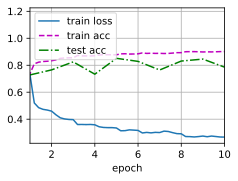

In [5]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Let us have a look at the scale parameter gamma and the shift parameter beta learned from the first batch normalization layer.

In [6]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([3.1088, 4.6735, 2.9107, 2.9786, 2.4793, 1.2701], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 1.6908,  2.1275, -3.3214,  1.4429,  1.9881,  1.7221], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

**7.5.5. Concise Implementation**

Compared with the BatchNorm class, which we just defined ourselves, we can use the BatchNorm class defined in high-level APIs from the deep learning framework directly. The code looks virtually identical to our implementation above.

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), 
    nn.BatchNorm2d(6), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), 
    nn.BatchNorm2d(16), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), 
    nn.Flatten(),
    nn.Linear(256, 120), 
    nn.BatchNorm1d(120), 
    nn.Sigmoid(),
    nn.Linear(120, 84), 
    nn.BatchNorm1d(84), 
    nn.Sigmoid(),
    nn.Linear(84, 10))

Below, we use the same hyperparameters to train our model. Note that as usual, the high-level API variant runs much faster because its code has been compiled to C++ or CUDA while our custom implementation must be interpreted by Python.

loss 0.268, train acc 0.902, test acc 0.853
33000.3 examples/sec on cuda:0


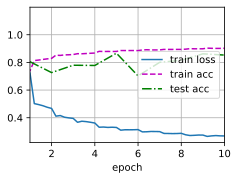

In [8]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**7.5.7. Summary**

During model training, batch normalization continuously adjusts the intermediate output of the neural network by utilizing the mean and standard deviation of the minibatch, so that the values of the intermediate output in each layer throughout the neural network are more stable.

The batch normalization methods for fully-connected layers and convolutional layers are slightly different.

Like a dropout layer, batch normalization layers have different computation results in training mode and prediction mode.

Batch normalization has many beneficial side effects, primarily that of regularization. On the other hand, the original motivation of reducing internal covariate shift seems not to be a valid explanation.